Ouvrir ce notebook dans :
<a href="https://colab.research.google.com/github/joanglaunes/deep_learning_image/blob/main/ViT.ipynb" target="_blank">Google Colab</a>
ou
<a href="https://rosenblatt.ens.math-info.univ-paris5.fr/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fjoanglaunes%2Fdeep_learning_image&urlpath=tree%2Fdeep_learning_image%2FViT.ipynb&branch=main" target="_blank">Rosenblatt</a>

# Vision Transformer

In [1]:
# Setup cell.
import time#, json
import numpy as np
import torch
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Transformer
In 2017, Vaswani et al introduced the Transformer in their paper ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762) to a) introduce parallelism and b) allow models to learn long-range dependencies. The paper not only led to famous models like BERT and GPT in the natural language processing community, but also an explosion of interest across fields, including vision. While here we introduce the model in the context of image captioning, the idea of attention itself is much more general.

# Transformer: Multi-Headed Attention

### Dot-Product Attention

Recall that attention can be viewed as an operation on a query $q\in\mathbb{R}^d$, a set of value vectors $\{v_1,\dots,v_n\}, v_i\in\mathbb{R}^d$, and a set of key vectors $\{k_1,\dots,k_n\}, k_i \in \mathbb{R}^d$, specified as
\begin{align}
c &= \sum_{i=1}^{n} v_i \alpha_i \\
\alpha_i &= \frac{\exp(k_i^\top q)}{\sum_{j=1}^{n} \exp(k_j^\top q)} \\
\end{align}

where $\alpha_i$ are frequently called the "attention weights", and the output $c\in\mathbb{R}^d$ is a correspondingly weighted average over the value vectors.

### Self-Attention
In Transformers, we perform self-attention, which means that the values, keys and query are derived from the input $X \in \mathbb{R}^{\ell \times d}$, where $\ell$ is our sequence length. Specifically, we learn parameter matrices $V,K,Q \in \mathbb{R}^{d\times d}$ to map our input $X$ as follows:

\begin{align}
v_i = Vx_i\ \ i \in \{1,\dots,\ell\}\\
k_i = Kx_i\ \ i \in \{1,\dots,\ell\}\\
q_i = Qx_i\ \ i \in \{1,\dots,\ell\}
\end{align}

### Multi-Headed Scaled Dot-Product Attention
In the case of multi-headed attention, we learn a parameter matrix for each head, which gives the model more expressivity to attend to different parts of the input. Let $h$ be number of heads, and $Y_i$ be the attention output of head $i$. Thus we learn individual matrices $Q_i$, $K_i$ and $V_i$. To keep our overall computation the same as the single-headed case, we choose $Q_i \in \mathbb{R}^{d\times d/h}$, $K_i \in \mathbb{R}^{d\times d/h}$ and $V_i \in \mathbb{R}^{d\times d/h}$. Adding in a scaling term $\frac{1}{\sqrt{d/h}}$ to our simple dot-product attention above, we have

$$
Y_i = \text{softmax}\bigg(\frac{(XQ_i)(XK_i)^\top}{\sqrt{d/h}}\bigg)(XV_i)
$$

where $Y_i\in\mathbb{R}^{\ell \times d/h}$, where $\ell$ is our sequence length.

In our implementation, we apply dropout to the attention weights (though in practice it could be used at any step):

$$
Y_i = \text{dropout}\bigg(\text{softmax}\bigg(\frac{(XQ_i)(XK_i)^\top}{\sqrt{d/h}}\bigg)\bigg)(XV_i)
$$

Finally, then the output of the self-attention is a linear transformation of the concatenation of the heads:

\begin{equation}
Y = [Y_1;\dots;Y_h]A
\end{equation}

were $A \in\mathbb{R}^{d\times d}$ and $[Y_1;\dots;Y_h]\in\mathbb{R}^{\ell \times d}$.

# Positional Encoding

While transformers are able to easily attend to any part of their input, the attention mechanism has no concept of token order. However, for many tasks (especially natural language processing), relative token order is very important. To recover this, the authors add a positional encoding to the embeddings of individual word tokens.

Let us define a matrix $P \in \mathbb{R}^{l\times d}$, where $P_{ij} = $

$$
\begin{cases}
\text{sin}\left(i \cdot 10000^{-\frac{j}{d}}\right) & \text{if j is even} \\
\text{cos}\left(i \cdot 10000^{-\frac{(j-1)}{d}}\right) & \text{otherwise} \\
\end{cases}
$$

Rather than directly passing an input $X \in \mathbb{R}^{l\times d}$ to our network, we instead pass $X + P$.

# Transformer Decoder Block

Transformer decoder layer consists of three modules: (1) self attention to process input sequence of vectors, (2) cross attention to process based on available context (i.e. image features in our case), (3) feedforward module to process each vector of the sequence independently.

The Transformer decoder layer has three main components: (1) a self-attention module that processes the input sequence of vectors, (2) a cross-attention module that incorporates additional context (e.g., image features in our case), and (3) a feedforward module that independently processes each vector in the sequence.

# Vision Transformer (ViT)

[Dosovitskiy et. al.](https://arxiv.org/abs/2010.11929) showed that applying a transformer model on a sequence of image patches (referred to as Vision Transformer) not only achieves impressive performance but also scales more effectively than convolutional neural networks when trained on large datasets. We will train it on the CIFAR-10 dataset.

Vision Transformer converts input image into a sequence of patches of fixed size and embed each patch into a latent vector.

The sequence of patch vectors is processed by transformer encoder layers, each consisting of a self-attention and a feed-forward module.

For classification, ViT divides the input image into patches and processes the sequence of patch vectors using a transformer. Finally, all the patch vectors are average-pooled and used to predict the image class. It uses the same 1D sinusoidal positional encoding to inject ordering information, though 2D sinusoidal and learned positional encodings are also valid choices.

We will first test the implementation by overfitting it on one training batch. Tune learning rate and weight decay accordingly.

In [2]:
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

train_data = CIFAR10(root='data', train=True, transform=transforms.ToTensor(), download=True)
test_data = CIFAR10(root='data', train=False, transform=transforms.ToTensor(), download=True)

# Specify the image classes
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

/opt/tljh/user/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Premier test d'apprentissage : on va entraîner le réseau ViT sur un batch unique d'images.
On va donc faire du sur-apprentissage, et le réseau devrait avoir de très mauvaises performances sur des données test. Il n'y a aucun intérêt à faire ça, à part pour vérifier que le réseau construit est capable d'être entraîné (par exemple vérifier qu'il n'y a pas de bug dans l'implémentation, et que le learning rate ou autres paramètres sont cohérents), ou encore comprendre mieux le principe du sur-apprentissage: le réseau apprend facilement car il y a peu de données donc c'est simple à classer, mais il ne pourra pas généraliser.

In [3]:
learning_rate = 1e-4  # Experiment with this
weight_decay = 1.e-4  # Experiment with this

# ici on charge uniquement un batch d'images, et donc
# l'entrainement est fait sur ce batch unique.
# 
batch = next(iter(DataLoader(train_data, batch_size=64, shuffle=False)))

# modèle ViT B-16 (le plus petit des modèles ViT de l'article originel):
model = torchvision.models.vit_b_16(image_size=32, num_classes=10)

# un modèle ViT encore plus petit :
#model = torchvision.models.vision_transformer.VisionTransformer(
#    image_size=32, patch_size=8, num_layers=6, num_heads=4, hidden_dim=128,
#    mlp_dim=256, num_classes=10)

loss_criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
model.train()

epochs = 100
for epoch in range(epochs):
    imgs, target = batch # toujours le même batch
    out = model(imgs)
    loss = loss_criterion(out, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    top1 = (out.argmax(-1) == target).float().mean().item()
    if epoch % 10 == 0:
      print(f"[{epoch}/{epochs}] Loss {loss.item():.6f}, Top-1 Accuracy: {top1:.3f}")


[0/100] Loss 2.302585, Top-1 Accuracy: 0.062
[10/100] Loss 2.114770, Top-1 Accuracy: 0.312
[20/100] Loss 1.876902, Top-1 Accuracy: 0.469
[30/100] Loss 1.467501, Top-1 Accuracy: 0.672
[40/100] Loss 1.076064, Top-1 Accuracy: 0.828
[50/100] Loss 0.695600, Top-1 Accuracy: 0.906
[60/100] Loss 0.409452, Top-1 Accuracy: 0.969
[70/100] Loss 0.258732, Top-1 Accuracy: 0.969
[80/100] Loss 0.178258, Top-1 Accuracy: 0.984
[90/100] Loss 0.123872, Top-1 Accuracy: 1.000


In [4]:
# You should get perfect 1.00 accuracy
print(f"Overfitting ViT on one batch. Top-1 accuracy: {top1}")

Overfitting ViT on one batch. Top-1 accuracy: 1.0


Now we will train it on the entire dataset.

In [6]:
def train_val(model, data_loader, train_optimizer, epoch, epochs, device='cpu'):
    is_train = train_optimizer is not None
    model.train() if is_train else model.eval()
    loss_criterion = torch.nn.CrossEntropyLoss()

    total_loss, total_correct_1, total_correct_5, total_num, data_bar = 0.0, 0.0, 0.0, 0, tqdm(data_loader)
    with (torch.enable_grad() if is_train else torch.no_grad()):
        for data, target in data_bar:
            data, target = data.to(device), target.to(device)
            out = model(data)
            loss = loss_criterion(out, target)

            if is_train:
                train_optimizer.zero_grad()
                loss.backward()
                train_optimizer.step()

            total_num += data.size(0)
            total_loss += loss.item() * data.size(0)
            prediction = torch.argsort(out, dim=-1, descending=True)
            total_correct_1 += torch.sum((prediction[:, 0:1] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            # total_correct_5 += torch.sum((prediction[:, 0:5] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()

            data_bar.set_description('{} Epoch: [{}/{}] Loss: {:.4f} ACC@1: {:.3f}%'
                                     .format('Train' if is_train else 'Test', epoch, epochs, total_loss / total_num,
                                             total_correct_1 / total_num))

    return total_loss / total_num, total_correct_1 / total_num, total_correct_5 / total_num

class ClassificationSolverViT:
    def __init__(self, train_data, test_data, model, **kwargs):
        self.model = model
        self.train_data = train_data
        self.test_data = test_data

        # Unpack keyword arguments
        self.learning_rate = kwargs.pop("learning_rate", 1.e-4)
        self.weight_decay = kwargs.pop("weight_decay", 0.0)
        self.batch_size = kwargs.pop("batch_size", 64)
        self.num_epochs = kwargs.pop("num_epochs", 2)

        self.optimizer = torch.optim.Adam(self.model.parameters(), self.learning_rate, weight_decay=self.weight_decay)
        self.loss_criterion = torch.nn.CrossEntropyLoss()

        self._reset()

    def _reset(self):

        self.epoch = 0
        self.results = {'train_loss': [], 'train_acc@1': [], 'test_loss': [], 'test_acc@1': []}

    def train(self, device='cpu'):
        train_loader = torch.utils.data.DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False)

        self.model.to(device)
        self.loss_criterion.to(device)

        best_acc = 0.0
        for epoch in range(self.num_epochs):
            train_loss, train_acc_1, _ = train_val(self.model, train_loader, self.optimizer, epoch, self.num_epochs, device)
            self.results['train_loss'].append(train_loss)
            self.results['train_acc@1'].append(train_acc_1)

            test_loss, test_acc_1, _ = train_val(self.model, test_loader, None, epoch, self.num_epochs, device)
            self.results['test_loss'].append(test_loss)
            self.results['test_acc@1'].append(test_acc_1)
            if test_acc_1 > best_acc:
                best_acc = test_acc_1
        
        self.results["best_test_acc"] = best_acc


learning_rate = 1e-4
weight_decay = 0.0
batch_size = 64


solver = ClassificationSolverViT(
    train_data=train_data,
    test_data=test_data,
    model=model,
    num_epochs = 10,
    learning_rate = learning_rate,
    weight_decay = weight_decay,
    batch_size = batch_size,
)

solver.train('cuda' if torch.cuda.is_available() else 'cpu')

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

In [7]:
print(f"Accuracy on test set: {solver.results['best_test_acc']}")

Accuracy on test set: 0.539


On obtient un taux de bon classement de 54%, ce qui n'est pas très bon, il faudrait entraîner plus pour améliorier. Cependant il faut se rappeler qu'il s'agit d'un problème à 10 classes, donc un classifieur aléatoire obitendrait un taux de 10% environ.

## Visualisation de quelques résultats

Quelques images test et leurs vraies classes:


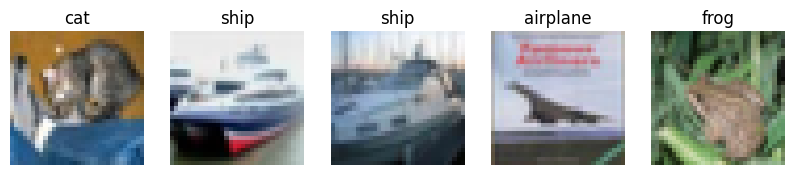

In [18]:
# on charge un batch d'images test avec leurs labels
images, labels = next(iter(DataLoader(test_data, batch_size=5, shuffle=False)))

print("Quelques images test et leurs vraies classes:")
for k in range(5):
    plt.subplot(1,5,k+1)
    plt.imshow(images[k,:,:,:].permute((1,2,0)).cpu())
    plt.axis('off')
    plt.title(classes[labels[k]])
plt.show()

In [20]:
# on applique le modèle au batch d'images test:
model.eval()
output = model(images.cuda())
output

tensor([[ 1.3086, -1.9801,  0.3301,  3.2820,  0.7262,  0.7993, -1.2750, -1.3206,
         -1.1480, -2.0248],
        [ 2.7810,  2.7809, -1.6168, -2.7489, -1.8624, -3.4746, -3.9967, -1.0307,
          3.3580,  4.4584],
        [ 3.3434, -0.0748, -0.7012, -1.9835, -0.2976, -2.2316, -4.4202,  1.0068,
          2.5274,  1.7220],
        [ 4.2582, -1.3537,  2.3085, -1.7005,  0.5892, -2.3764, -3.3559, -0.0405,
          0.2931, -1.0066],
        [-2.5544, -2.2366,  1.1643,  1.7261,  3.2755, -0.0809,  5.8482, -3.4810,
         -1.0279, -3.4869]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [21]:
# la sortie est pour chaque image un vecteur de taille 10 qu'on peut convertir en vecteur
# de probabilités des classes via un softmax:
torch.softmax(output,axis=1)

tensor([[9.9634e-02, 3.7164e-03, 3.7448e-02, 7.1688e-01, 5.5648e-02, 5.9868e-02,
         7.5223e-03, 7.1873e-03, 8.5408e-03, 3.5540e-03],
        [1.0889e-01, 1.0888e-01, 1.3398e-03, 4.3189e-04, 1.0480e-03, 2.0904e-04,
         1.2401e-04, 2.4075e-03, 1.9391e-01, 5.8276e-01],
        [5.4884e-01, 1.7985e-02, 9.6139e-03, 2.6669e-03, 1.4393e-02, 2.0809e-03,
         2.3321e-04, 5.3048e-02, 2.4268e-01, 1.0846e-01],
        [8.2400e-01, 3.0111e-03, 1.1727e-01, 2.1285e-03, 2.1013e-02, 1.0828e-03,
         4.0660e-04, 1.1195e-02, 1.5629e-02, 4.2604e-03],
        [2.0275e-04, 2.7861e-04, 8.3555e-03, 1.4654e-02, 6.9003e-02, 2.4053e-03,
         9.0401e-01, 8.0267e-05, 9.3306e-04, 7.9793e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [22]:
# On peut ensuite récupérer les indices de probabilité maximale
# qui vont correspondre aux classes estimées.
# (N.B. on pourrait en fait le faire directement sans calculer 
# le softmax car la proba est maximale lorsque l'output est maximal,
# mais c'est plus cohérent de la calculer sur le vecteur de probabilités
labels_est = torch.argmax(torch.softmax(output,axis=1), axis=1)

Quelques images test et leurs classes estimées:


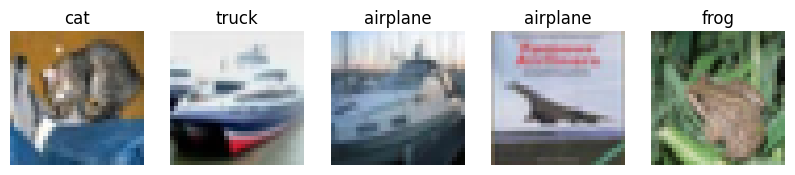

In [23]:
# on peut à présent afficher:
print("Quelques images test et leurs classes estimées:")
for k in range(5):
    plt.subplot(1,5,k+1)
    plt.imshow(images[k,:,:,:].permute((1,2,0)).cpu())
    plt.axis('off')
    plt.title(classes[labels_est[k]])
plt.show()